In [178]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [194]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

import fannypack
from lib import dpf, panda_models, panda_datasets, panda_training

print(torch.__version__, np.__version__)

1.4.0 1.18.1


In [197]:
# Experiment configuration
experiment_name = "dpf_feb18_biggermodel"
dataset_args = {
    'use_proprioception': True,
    'use_haptics': True,
    'use_vision': True,
    'vision_interval': 2,
}

In [198]:
# Create models & training buddy

dynamics_model = panda_models.PandaDynamicsModel()
measurement_model = panda_models.PandaSimpleMeasurementModel()

pf_model = panda_models.PandaParticleFilterNetwork(
    dynamics_model,
    measurement_model
)

buddy = fannypack.utils.Buddy(
    experiment_name,
    pf_model,
    optimizer_names=["e2e", "dynamics", "measurement"]
)

[buddy-dpf_feb18_biggermodel] Using device: cuda
[buddy-dpf_feb18_biggermodel] No checkpoint found


# Dynamics Model Pre-Training

In [199]:
dynamics_trainset = panda_datasets.PandaDynamicsDataset(
    "data/gentle_push_10.hdf5",
    **dataset_args
)
dynamics_recurrent_trainset = panda_datasets.PandaSubsequenceDataset(
    "data/gentle_push_10.hdf5",
    subsequence_length=32,
    **dataset_args
)

Parsed data: 2027 active, 363 inactive
Keeping: 363


In [203]:
dataloader = torch.utils.data.DataLoader(dynamics_trainset, batch_size=32, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.02, .02)

for i in range(30):
    print("Training epoch", i)
    panda_training.train_dynamics(buddy, pf_model, dataloader, log_interval=1)
    print()


Training epoch 0



Epoch loss: 0.0033752127

Training epoch 1



Epoch loss: 0.0025650137

Training epoch 2



Epoch loss: 0.0026448527

Training epoch 3



Epoch loss: 0.0024074824

Training epoch 4



Epoch loss: 0.002516053

Training epoch 5



Epoch loss: 0.0024669664

Training epoch 6



Epoch loss: 0.0024225544

Training epoch 7



Epoch loss: 0.002409133

Training epoch 8



Epoch loss: 0.0023797662

Training epoch 9



Epoch loss: 0.002327364

Training epoch 10



Epoch loss: 0.0023525783

Training epoch 11



Epoch loss: 0.0022862717

Training epoch 12



Epoch loss: 0.002263167

Training epoch 13



Epoch loss: 0.0023400998

Training epoch 14



Epoch loss: 0.0022700364

Training epoch 15



Epoch loss: 0.0022596912

Training epoch 16



Epoch loss: 0.0022535578

Training epoch 17



Epoch loss: 0.0022532297

Training epoch 18



Epoch loss: 0.002221431

Training epoch 19



Epoch loss: 0.0022042543

Training epoch 20



Epoch loss: 0.0022172031

Training epoch 21



Epoch loss: 0.0023213527

Training epoch 22



Epoch loss: 0.0021135826

Training epoch 23



Epoch loss: 0.0021242837

Training epoch 24



Epoch loss: 0.002127593

Training epoch 25



Epoch loss: 0.0021051785

Training epoch 26



Epoch loss: 0.0021504983

Training epoch 27



Epoch loss: 0.0020497579

Training epoch 28



Epoch loss: 0.0020118973

Training epoch 29



Epoch loss: 0.0020988844



In [205]:
dataloader = torch.utils.data.DataLoader(dynamics_recurrent_trainset, batch_size=16, shuffle=True, num_workers=2)
pf_model.dynamics_model.state_noise_stddev = (.02, .02)

for i in range(30):
    print("Training epoch", i)
    panda_training.train_dynamics_recurrent(buddy, pf_model, dataloader, log_interval=1, loss_type='l2')
    print()


Training epoch 0



Epoch loss: 0.003547173

Training epoch 1



Epoch loss: 0.0041046287

Training epoch 2



Epoch loss: 0.0034224573

Training epoch 3



Epoch loss: 0.0030329288

Training epoch 4



Epoch loss: 0.0018386865

Training epoch 5



Epoch loss: 0.0020227912

Training epoch 6



Epoch loss: 0.0016385358

Training epoch 7



Epoch loss: 0.0010496916

Training epoch 8



Epoch loss: 0.001312664

Training epoch 9



Epoch loss: 0.0011061742

Training epoch 10



Epoch loss: 0.0010461253

Training epoch 11



Epoch loss: 0.0008392873

Training epoch 12



Epoch loss: 0.0007679983

Training epoch 13



Epoch loss: 0.00071725243

Training epoch 14



Epoch loss: 0.00075589615

Training epoch 15



Epoch loss: 0.0008158825

Training epoch 16



Epoch loss: 0.00072028703

Training epoch 17



Epoch loss: 0.0006706611

Training epoch 18



Epoch loss: 0.00070021086

Training epoch 19



Epoch loss: 0.0006996044

Training epoch 20



Epoch loss: 0.00074380386

Training epoch 21



Epoch loss: 0.00081247865

Training epoch 22


KeyboardInterrupt: 

# Measurement Model Pre-Training

In [ ]:

measurement_trainset = panda_datasets.PandaMeasurementDataset(
    "data/gentle_push_100.hdf5",
    samples_per_pair=10,
    **dataset_args
)

In [ ]:
measurement_trainset_loader = torch.utils.data.DataLoader(
    measurement_trainset,
    batch_size=64,
    shuffle=True,
    num_workers=16)

for i in range(15):
    print("Training epoch", i)
    panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=20)
    print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=64, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()

# measurement_trainset_loader = torch.utils.data.DataLoader(measurement_trainset, batch_size=256, shuffle=True, num_workers=2)
# for i in range(1):
#     print("Training epoch", i)
#     panda_training.train_measurement(buddy, pf_model, measurement_trainset_loader, log_interval=100)
#     print()



In [ ]:
buddy.save_checkpoint(label="before_e2e_training")

# End-to-end Training

In [ ]:
# Create end-to-end dataset

e2e_trainset = panda_datasets.PandaParticleFilterDataset(
    "data/gentle_push_100.hdf5",
    subsequence_length=16,
    particle_count=30,
    particle_stddev=(.1, .1),
    **dataset_args
)

In [ ]:
print(len(e2e_trainset.subsequences))

In [ ]:
##### Train end-to-end
pf_model.dynamics_model.state_noise_stddev = (0.05, 0.05)

pf_model.freeze_measurement_model = False
pf_model.freeze_dynamics_model = True

# e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
# for i in range(3):
#     print("Training epoch", i)
#     panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse", log_interval=100)

e2e_trainset_loader = torch.utils.data.DataLoader(e2e_trainset, batch_size=32, shuffle=True, num_workers=2)
for i in range(20):
    print("Training epoch", i)
    panda_training.train_e2e(buddy, pf_model, e2e_trainset_loader, loss_type="mse")

In [ ]:
buddy.save_checkpoint()

# Model eval

In [186]:
eval_trajectories = panda_datasets.load_trajectories(
    "data/gentle_push_10.hdf5",
    **dataset_args
)

### Final Model

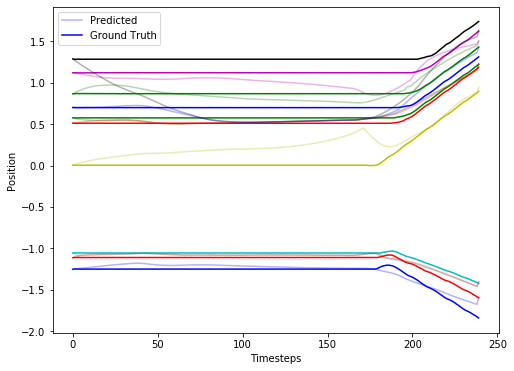

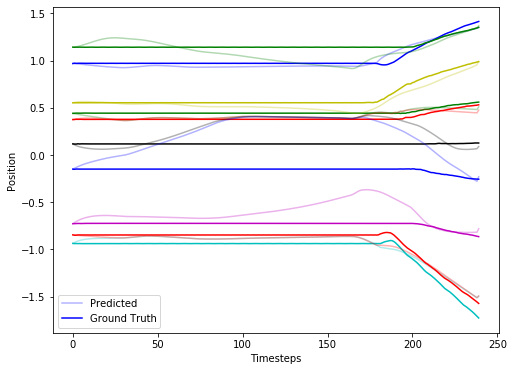

X RMSE:  0.2045652959819013
Y RMSE:  0.16082547676660064
(0.0, 0.0)


In [204]:
pf_model.dynamics_model.state_noise_stddev = (0., 0.)
# pf_model.dynamics_model.state_noise_stddev = (1., 1.)
pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)
print(pf_model.dynamics_model.state_noise_stddev)

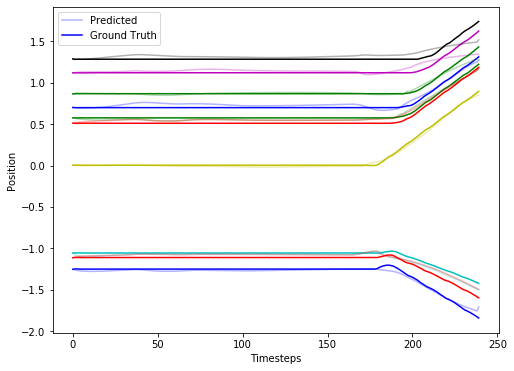

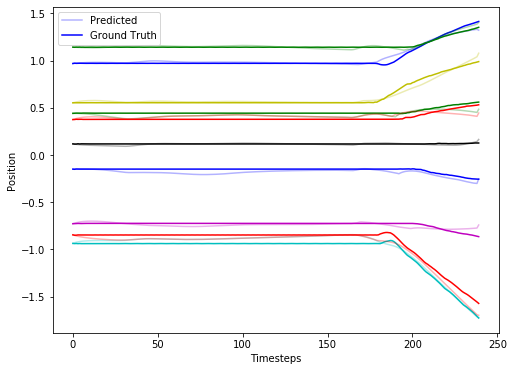

X RMSE:  0.038565583851118655
Y RMSE:  0.03340147682294363
(0.0, 0.0)


In [206]:
pf_model.dynamics_model.state_noise_stddev = (0., 0.)
# pf_model.dynamics_model.state_noise_stddev = (1., 1.)
pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)
print(pf_model.dynamics_model.state_noise_stddev)

### Model without end-to-end training

In [ ]:
pf_model.dynamics_model.state_noise = (0.005, 0.005)


# Back up model
buddy.save_checkpoint()

# Load the pre-end-to-end-training version of the model & evaluate
buddy.load_checkpoint(label="before_e2e_training")

pred, actual = panda_training.rollout(pf_model, eval_trajectories, start_time=0, max_timesteps=1000, particle_count=200, noisy_dynamics=True)
panda_training.eval_rollout(pred, actual, plot=True)

# Restore model
buddy.load_checkpoint()